In [ ]:
import os
import cv2
import time
import random
import numpy as np

import tensorflow as tf
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
tf.__version__, np.__version__

('2.12.0', '1.22.4')

In [ ]:
# Setting random seeds to enable consistency while testing.
random.seed(5)
np.random.seed(5)
tf.random.set_seed(5)

ROOT = "/content/drive/MyDrive/face-recognition-dataset/Extracted Faces/Extracted Faces"

def read_image(index):
    path = os.path.join(ROOT, index[0], index[1])
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [ ]:
def split_dataset(directory, split=0.85):
    folders = os.listdir(directory)
    num_train = int(len(folders)*split)

    random.shuffle(folders)

    train_list, test_list = {}, {}

    # Creating Train-list
    for folder in folders[:num_train]:
        num_files = len(os.listdir(os.path.join(directory, folder)))
        train_list[folder] = num_files

    # Creating Test-list
    for folder in folders[num_train:]:
        num_files = len(os.listdir(os.path.join(directory, folder)))
        test_list[folder] = num_files

    return train_list, test_list

train_list, test_list = split_dataset(ROOT, split=0.85)
print("Length of training list:", len(train_list))
print("Length of testing list :", len(test_list))

# train_list, test list contains the folder names along with the number of files in the folder.
print("\nTest List:", test_list)

Length of training list: 1125
Length of testing list : 199

Test List: {'686': 5, '694': 3, '1024': 8, '545': 3, '940': 2, '507': 2, '631': 15, '1256': 8, '1138': 3, '968': 2, '1386': 3, '258': 2, '1238': 2, '555': 13, '480': 3, '994': 38, '535': 2, '713': 2, '1283': 3, '1440': 12, '700': 10, '151': 3, '1304': 2, '1033': 2, '1135': 5, '1063': 3, '492': 2, '1015': 3, '157': 3, '267': 2, '655': 10, '1026': 2, '261': 8, '110': 29, '747': 3, '1626': 4, '174': 2, '807': 5, '958': 2, '549': 3, '508': 3, '976': 6, '608': 4, '999': 3, '1187': 2, '1082': 32, '233': 2, '918': 2, '169': 2, '557': 2, '844': 6, '1502': 2, '192': 2, '744': 2, '876': 10, '236': 2, '161': 2, '824': 14, '1666': 14, '1172': 2, '1662': 7, '336': 3, '649': 12, '1007': 11, '1441': 2, '1487': 4, '1301': 2, '847': 2, '921': 2, '444': 3, '670': 3, '41': 4, '1433': 20, '814': 2, '1105': 2, '1552': 4, '1474': 2, '214': 6, '991': 4, '59': 4, '191': 2, '1545': 4, '255': 2, '582': 2, '600': 4, '597': 2, '1578': 18, '1128': 7, '521

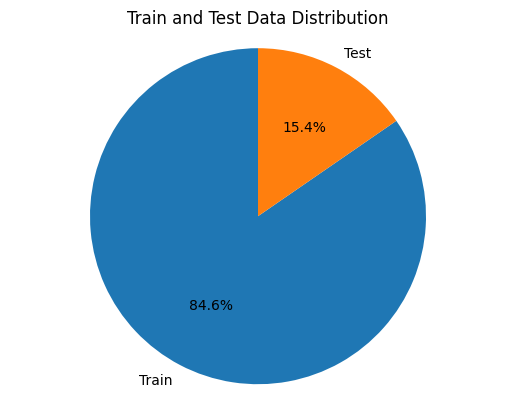

In [ ]:
# Extracting folder names and number of files from train and test dictionaries
train_folders = list(train_list.keys())
train_file_counts = list(train_list.values())

test_folders = list(test_list.keys())
test_file_counts = list(test_list.values())

# Creating labels for the pie chart
labels = ['Train', 'Test']

# Creating data for the pie chart
sizes = [sum(train_file_counts), sum(test_file_counts)]

# Creating the pie chart
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Train and Test Data Distribution')
plt.show()

In [ ]:
def create_triplets(directory, folder_list, max_files=15):
    triplets = []
    folders = list(folder_list.keys())

    for folder in folders:
        path = os.path.join(directory, folder)
        files = list(os.listdir(path))[:max_files]
        num_files = len(files)

        for i in range(num_files-1):
            for j in range(i+1, num_files):
                anchor = (folder, f"{i}.jpg")
                positive = (folder, f"{j}.jpg")

                neg_folder = folder
                while neg_folder == folder:
                    neg_folder = random.choice(folders)
                neg_file = random.randint(0, folder_list[neg_folder]-1)
                negative = (neg_folder, f"{neg_file}.jpg")

                triplets.append((anchor, positive, negative))

    random.shuffle(triplets)
    return triplets

In [ ]:
train_triplet = create_triplets(ROOT, train_list)
test_triplet  = create_triplets(ROOT, test_list)

print("Number of training triplets:", len(train_triplet))
print("Number of testing triplets :", len(test_triplet))

print("\nExamples of triplets:")
for i in range(5):
    print(train_triplet[i])

Number of training triplets: 13788
Number of testing triplets : 2643

Examples of triplets:
(('723', '4.jpg'), ('723', '7.jpg'), ('1460', '1.jpg'))
(('526', '5.jpg'), ('526', '10.jpg'), ('1066', '0.jpg'))
(('1280', '5.jpg'), ('1280', '9.jpg'), ('1027', '1.jpg'))
(('1095', '1.jpg'), ('1095', '3.jpg'), ('408', '3.jpg'))
(('350', '7.jpg'), ('350', '8.jpg'), ('1201', '3.jpg'))


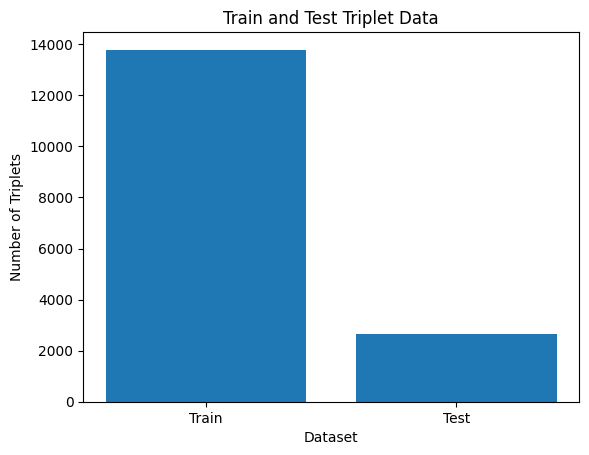

In [ ]:
train_triplet = create_triplets(ROOT, train_list)
test_triplet  = create_triplets(ROOT, test_list)

# Counting the number of triplets in each dataset
num_train_triplets = len(train_triplet)
num_test_triplets = len(test_triplet)

# Creating labels for the bar chart
labels = ['Train', 'Test']

# Creating data for the bar chart
counts = [num_train_triplets, num_test_triplets]

# Creating the bar chart
plt.bar(labels, counts)
plt.xlabel('Dataset')
plt.ylabel('Number of Triplets')
plt.title('Train and Test Triplet Data')
plt.show()


In [ ]:
def get_batch(triplet_list, batch_size=512, preprocess=True):
    batch_steps = len(triplet_list)//batch_size

    for i in range(batch_steps+1):
        anchor   = []
        positive = []
        negative = []

        j = i*batch_size
        while j<(i+1)*batch_size and j<len(triplet_list):
            a, p, n = triplet_list[j]
            anchor.append(read_image(a))
            positive.append(read_image(p))
            negative.append(read_image(n))
            j+=1

        anchor = np.array(anchor)
        positive = np.array(positive)
        negative = np.array(negative)

        if preprocess:
            anchor = preprocess_input(anchor)
            positive = preprocess_input(positive)
            negative = preprocess_input(negative)

        yield ([anchor, positive, negative])

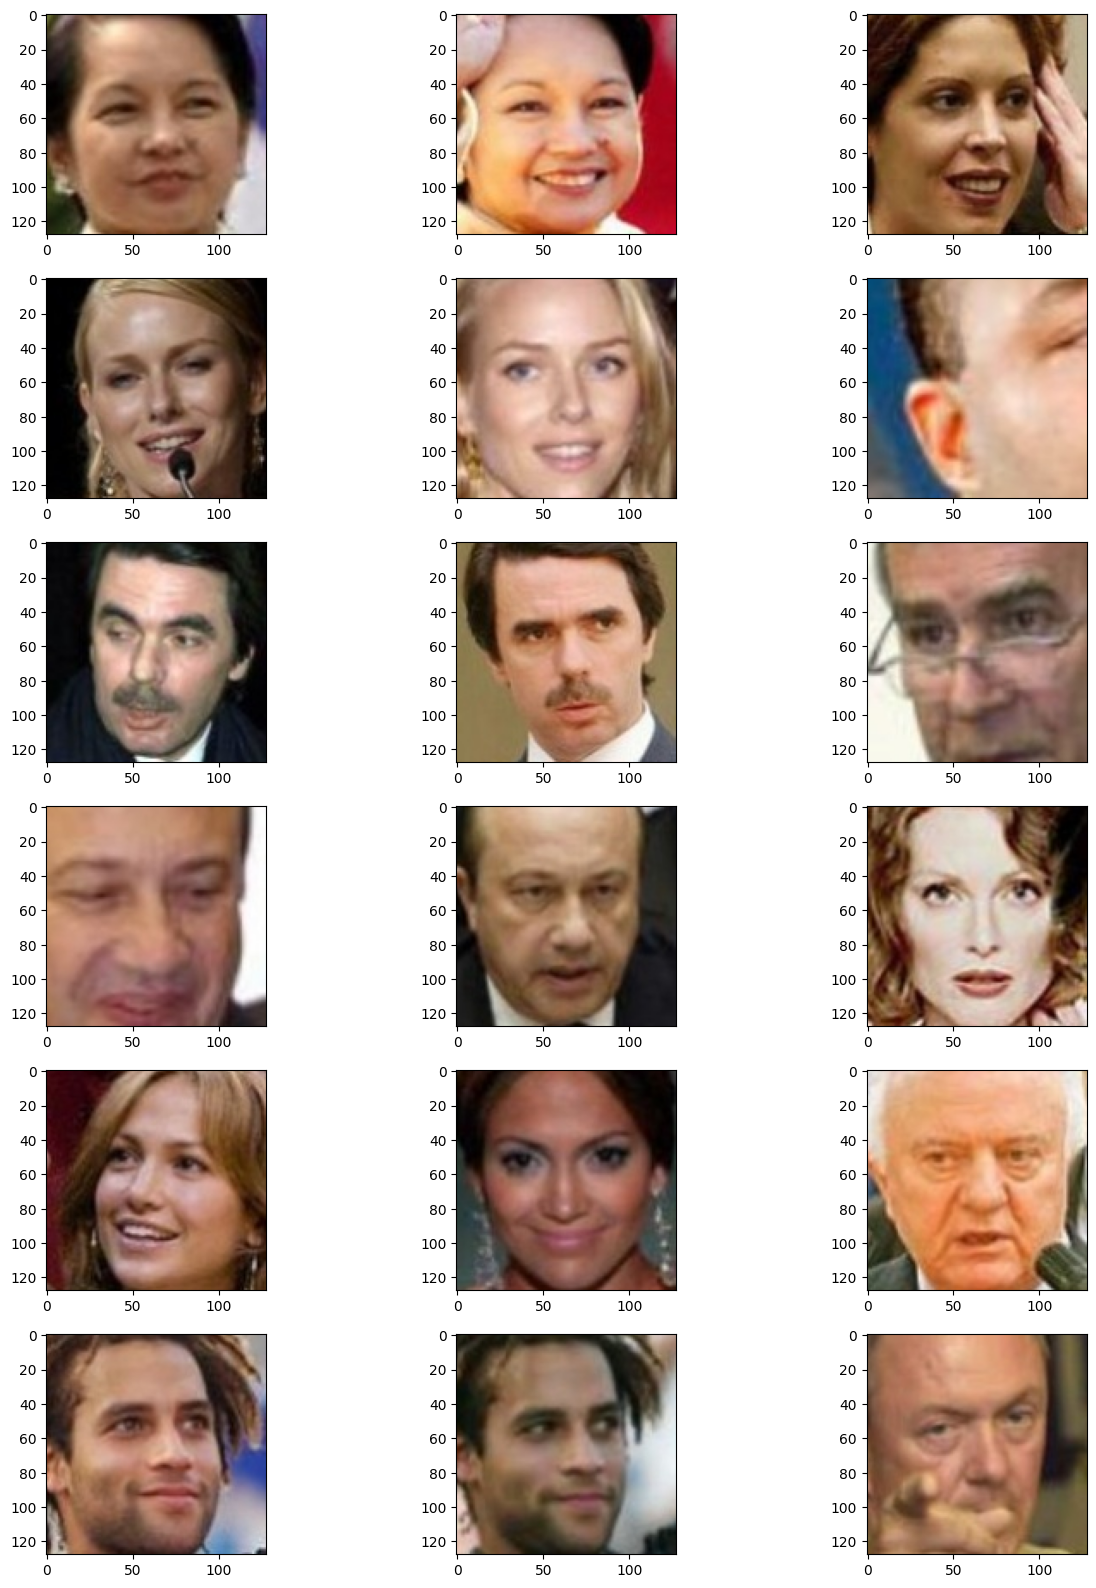

In [ ]:
num_plots = 6

f, axes = plt.subplots(num_plots, 3, figsize=(15, 20))

for x in get_batch(train_triplet, batch_size=num_plots, preprocess=False):
    a,p,n = x
    for i in range(num_plots):
        axes[i, 0].imshow(a[i])
        axes[i, 1].imshow(p[i])
        axes[i, 2].imshow(n[i])
        i+=1
    break


In [ ]:
from tensorflow.keras import backend, layers, metrics

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
def get_encoder(input_shape):
    """ Returns the image encoding model """

    pretrained_model = MobileNetV2(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False,
        pooling='avg',
    )

    for i in range(len(pretrained_model.layers)-31):
        pretrained_model.layers[i].trainable = False

    encode_model = Sequential([
        pretrained_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(256, activation="relu"),
        layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
    ], name="Encode_Model")
    return encode_model

In [ ]:
class DistanceLayer(layers.Layer):
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


def get_siamese_network(input_shape = (128, 128, 3)):
    encoder = get_encoder(input_shape)

    # Input Layers for the images
    anchor_input   = layers.Input(input_shape, name="Anchor_Input")
    positive_input = layers.Input(input_shape, name="Positive_Input")
    negative_input = layers.Input(input_shape, name="Negative_Input")

    ## Generate the encodings (feature vectors) for the images
    encoded_a = encoder(anchor_input)
    encoded_p = encoder(positive_input)
    encoded_n = encoder(negative_input)

    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    distances = DistanceLayer()(
        encoder(anchor_input),
        encoder(positive_input),
        encoder(negative_input)
    )

    # Creating the Model
    siamese_network = Model(
        inputs  = [anchor_input, positive_input, negative_input],
        outputs = distances,
        name = "Siamese_Network"
    )
    return siamese_network

siamese_network = get_siamese_network()
siamese_network.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "Siamese_Network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Anchor_Input (InputLayer)      [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Positive_Input (InputLayer)    [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Negative_Input (InputLayer)    [(None, 128, 128, 3  0           []                               
                     

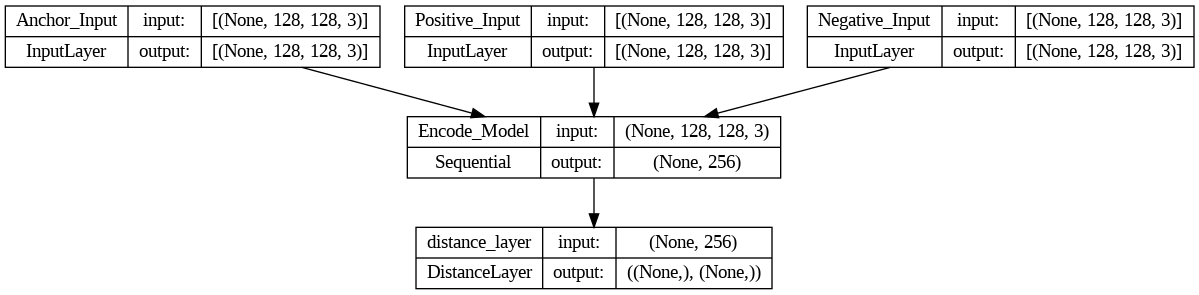

In [ ]:
plot_model(siamese_network, show_shapes=True, show_layer_names=True)

In [ ]:
class SiameseModel(Model):
    # Builds a Siamese model based on a base-model
    def __init__(self, siamese_network, margin=0.7):
        super(SiameseModel, self).__init__()

        self.margin = margin
        self.siamese_network = siamese_network
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape get the gradients when we compute loss, and uses them to update the weights
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # Get the two distances from the network, then compute the triplet loss
        ap_distance, an_distance = self.siamese_network(data)
        loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics so the reset_states() can be called automatically.
        return [self.loss_tracker]

In [ ]:
siamese_model = SiameseModel(siamese_network)

optimizer = Adam(learning_rate=1e-3, epsilon=1e-01)
siamese_model.compile(optimizer=optimizer)

In [ ]:
def test_on_triplets(batch_size = 256):
    pos_scores, neg_scores = [], []

    for data in get_batch(test_triplet, batch_size=batch_size):
        prediction = siamese_model.predict(data)
        pos_scores += list(prediction[0])
        neg_scores += list(prediction[1])

    accuracy = np.sum(np.array(pos_scores) < np.array(neg_scores)) / len(pos_scores)
    ap_mean = np.mean(pos_scores)
    an_mean = np.mean(neg_scores)
    ap_stds = np.std(pos_scores)
    an_stds = np.std(neg_scores)

    print(f"Accuracy on test = {accuracy:.5f}")
    return (accuracy, ap_mean, an_mean, ap_stds, an_stds)

In [ ]:
save_all = True
epochs = 5
batch_size = 350

max_acc = 0
train_loss = []
test_metrics = []

for epoch in range(1, epochs+1):
    t = time.time()

    # Training the model on train data
    epoch_loss = []
    for data in get_batch(train_triplet, batch_size=batch_size):
        loss = siamese_model.train_on_batch(data)
        epoch_loss.append(loss)
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    train_loss.append(epoch_loss)

    print(f"\nEPOCH: {epoch} \t (Epoch done in {int(time.time()-t)} sec)")
    print(f"Loss on train    = {epoch_loss:.5f}")

    # Testing the model on test data
    metric = test_on_triplets(batch_size=batch_size)
    test_metrics.append(metric)
    accuracy = metric[0]

    # Saving the model weights
    if save_all or accuracy>=max_acc:
        siamese_model.save_weights("siamese_model")
        max_acc = accuracy

# Saving the model after all epochs run
siamese_model.save_weights("siamese_model-final")


EPOCH: 1 	 (Epoch done in 956 sec)
Loss on train    = 0.08986
7/7 [==============================] - 5s 678ms/step
Accuracy on test = 0.89860

EPOCH: 2 	 (Epoch done in 922 sec)
Loss on train    = 0.07771
7/7 [==============================] - 6s 703ms/step
Accuracy on test = 0.89671

EPOCH: 3 	 (Epoch done in 921 sec)
Loss on train    = 0.06519
7/7 [==============================] - 6s 831ms/step
Accuracy on test = 0.88687

EPOCH: 4 	 (Epoch done in 894 sec)
Loss on train    = 0.06324
7/7 [==============================] - 5s 677ms/step
Accuracy on test = 0.88838

EPOCH: 5 	 (Epoch done in 909 sec)
Loss on train    = 0.04810
7/7 [==============================] - 7s 1s/step
Accuracy on test = 0.89633


In [ ]:
def extract_encoder(model):
    encoder = get_encoder((128, 128, 3))
    i=0
    for e_layer in model.layers[0].layers[3].layers:
        layer_weight = e_layer.get_weights()
        encoder.layers[i].set_weights(layer_weight)
        i+=1
    return encoder

encoder = extract_encoder(siamese_model)
encoder.save_weights("encoder")
encoder.summary()

Model: "Encode_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 flatten_1 (Flatten)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               655872    
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 lambda_1 (Lambda)           (None, 256)              

In [ ]:
def classify_images(face_list1, face_list2, threshold=1.3):
    # Getting the encodings for the passed faces
    tensor1 = encoder.predict(face_list1)
    tensor2 = encoder.predict(face_list2)

    distance = np.sum(np.square(tensor1-tensor2), axis=-1)
    prediction = np.where(distance<=threshold, 0, 1)
    return prediction

8/8 [==============================] - 2s 299ms/step

Accuracy of model: 0.814453125



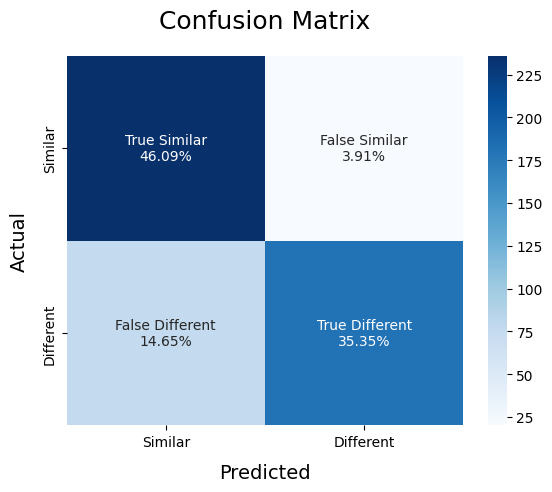

In [ ]:
def ModelMetrics(pos_list, neg_list):
    true = np.array([0]*len(pos_list)+[1]*len(neg_list))
    pred = np.append(pos_list, neg_list)

    # Compute and print the accuracy
    print(f"\nAccuracy of model: {accuracy_score(true, pred)}\n")

    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(true, pred)

    categories  = ['Similar','Different']
    names = ['True Similar','False Similar', 'False Different','True Different']
    percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)


pos_list = np.array([])
neg_list = np.array([])

for data in get_batch(test_triplet, batch_size=256):
    a, p, n = data
    pos_list = np.append(pos_list, classify_images(a, p))
    neg_list = np.append(neg_list, classify_images(a, n))
    break

ModelMetrics(pos_list, neg_list)

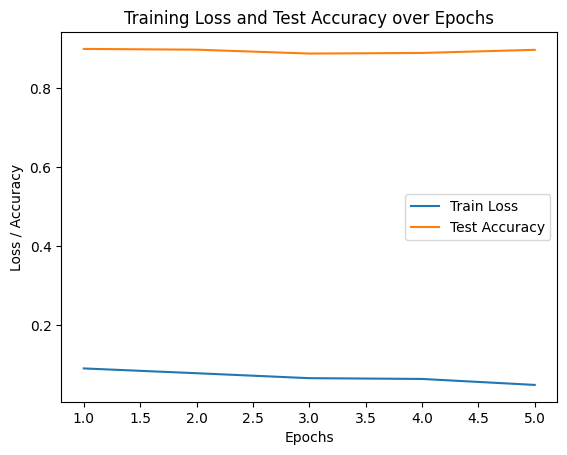

In [ ]:
import matplotlib.pyplot as plt

# Extracting the accuracy from test metrics
accuracy = [metric[0] for metric in test_metrics]

# Creating the epochs range
epochs = range(1, len(train_loss) + 1)

# Plotting the train loss
plt.plot(epochs, train_loss, label='Train Loss')

# Plotting the test accuracy
plt.plot(epochs, accuracy, label='Test Accuracy')

# Setting labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss / Accuracy')
plt.title('Training Loss and Test Accuracy over Epochs')

# Adding legend
plt.legend()

# Displaying the accuracy graph
plt.show()


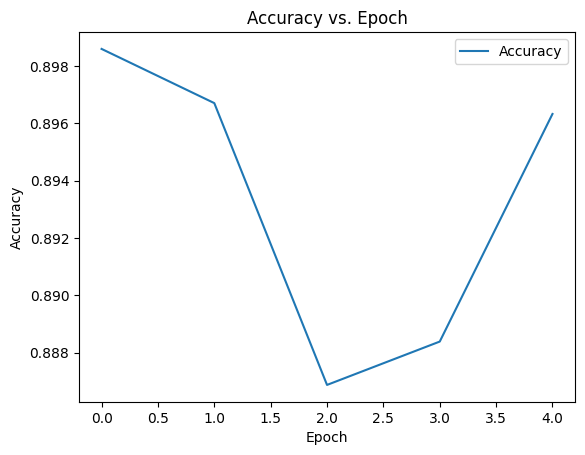

In [ ]:
import matplotlib.pyplot as plt

# Get the accuracy values from the test_metrics list
accuracy_values = [metric[0] for metric in test_metrics]

# Create a plot of the accuracy values
plt.plot(accuracy_values, label="Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Epoch")
plt.legend()
plt.show()

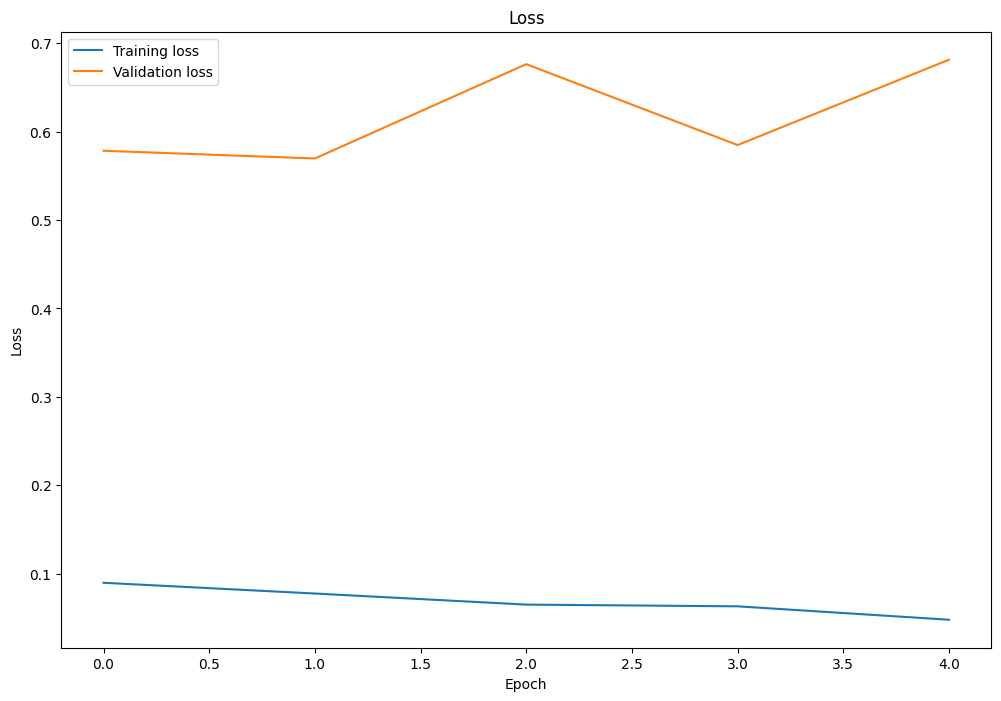

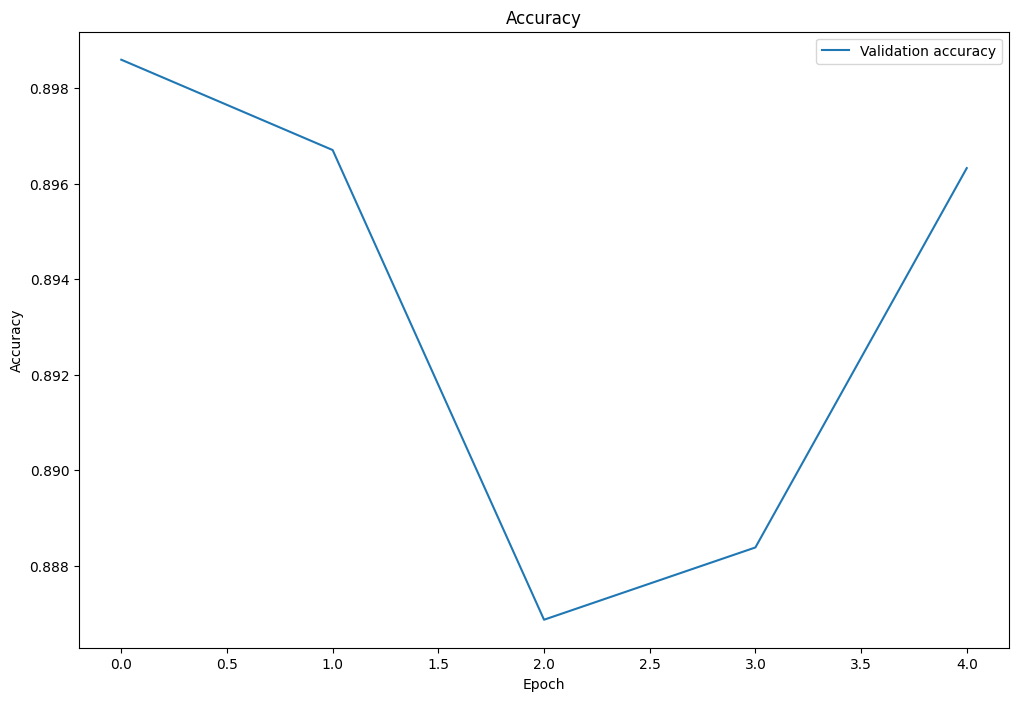

In [ ]:
def plot_graphs(train_loss, test_metrics):
    plt.figure(figsize=(12, 8))
    plt.plot(train_loss, label="Training loss")
    plt.plot([metric[1] for metric in test_metrics], label="Validation loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.figure(figsize=(12, 8))
    plt.plot([metric[0] for metric in test_metrics], label="Validation accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.show()

plot_graphs(train_loss, test_metrics)